<a href="https://colab.research.google.com/github/Ben-Foxman/QOSF_Submission/blob/main/QOSF2021_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ben Foxman, QOSF Screening Test for Spring 2021. Problem 2 - Error  Detection and Correction for a Simple Quantum Circuit. 

In [42]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram
from qiskit.test.mock import FakeVigo
from qiskit.circuit.library import IGate, XGate, ZGate
from matplotlib import pyplot as plt
import sys

**Explanation of the Error Detection Mechanism**.

 The first important observation to make about the setup of our error-prone circuit is that *no matter what combination of error gates appear in the circuit, the resulting state of the system is always one of the four Bell states* (The wikipedia article provides a nice introduction to what Bell states are). The specific bell state created by some combination of error gates are as follows (In each case, the error gate on qubit 0 is listed first):

(I, I) $\rightarrow \Phi^+$, (X, I) $\rightarrow \Phi^+$, (I, X) $\rightarrow \Psi^+$, (X, X) $\rightarrow \Psi^+$, (I, Z) $\rightarrow \Phi^+$, (X, Z) $\rightarrow \Phi^+$, (Z, I) $\rightarrow \Phi^-$, (Z, X) $\rightarrow \Psi^-$, (Z, Z) $\rightarrow \Phi^-$. 

To see why this is the case, one can use matrix multiplication of the corresponding matrices, or just analyze the behavior of CNOT on the various control and target qubits. 

Thus, we can simplify the problem of error detection (and correction!) to the following: 

*Given that our system is in an arbitrary bell state, how do we transform it into $\Phi^+$?.*

As it turns out, this is very easy to do if we shift our focus from the computational basis to the Hadamard basis, as the bell states are just linear combinations of Hadamard basis states. Once we are working in the Hadamard basis, there is a very nice correspondence between the 4 bell states and bit strings of length 2. This mapping is also the essence of the superdense coding protocol. The wikipedia article "Superdense Coding" is a great resource for understanding the inner workings of this map between bits and qubits.

Via this mapping, our desired bell state $\Phi^+$, becomes the bit string 00. Hence, all we need to do is send our bell state through the map, add some gates to turn the 2-bit string we get into 00, and send 00 back the other direction, giving us the correct bell state $\Phi^+$.

In [43]:
# initialize the sub-circuit responsible for error-checking
error_checker = QuantumCircuit(4)
# go to Hadamard basis
error_checker.cx(0, 1)
error_checker.h(0)
# change the logical qubits to 00, using 2 throwaway qubits
error_checker.cx(0, 2)
error_checker.cx(2, 0)
error_checker.cx(1, 3)
error_checker.cx(3, 1)
# revert back to the computational basis and set up desired bell state
error_checker.h(0)
error_checker.cx(0, 1)
error_checker_inst = error_checker.to_instruction()
print(error_checker.depth())


6


Since we will be using a noise-free simulation of Quantum Computer, we don't have to worry about many common sources of additional error when executing circuits on a real quantum computer. However, we should still design our algorithm as if it were to be used on a real quantum computer. Notice that our error-correcting circuit exclusively uses CNOT and Hadamard gates, both members of common universal gate sets. This circuit also has a relatively small depth (6), and requires only 2 ancillary qubits. In practice, keeping these numbers small helps to increase the fidelity of the circuit.   

Next, we will create subcircuits consisting of I, X, and Z gates, which will eventually be inserted probabilistically into the circuit.

In [44]:
# create I, X, and Z gates which can be inserted probabilistically into the circuit
i = QuantumCircuit(1)
i_err = i.to_instruction()
x = QuantumCircuit(1)
x.x(0)
x_err = x.to_instruction()
z = QuantumCircuit(1)
z.z(0)
z_err = z.to_instruction()

Now, we write a function to create a circuit with error gates chosen according to the specified probability distribution. 

In [45]:
 """
init_circuits: create a list of circuits to perform measurements on.

error_probabilities: 3-tuple giving probability of (I, X, Z) error gates. 
These numbers must be non_zero and sum to 1. 
iters: # of circuits to create
fix_errors: whether or not to add the error correcting circuit

returns: a list of circuits, initialized according to arguments
"""
def init_circuits(error_probabilities, iters, fix_errors):
  circs = [] # circuits generated with errors according to error_probabilities
  for _ in range(iters):
    # create the circuit and add error gates
    circ = QuantumCircuit(4, 4)
    circ.h(0)
    # error check the error probabilities
    if 0 in error_probabilities or np.sum(error_probabilities) != 1:
      sys.exit("Probabilities must sum to one, and all be nonzero.")
    # add error gates probabilistically
    error_gates = np.random.choice([i_err, x_err, z_err], 2, p=error_probabilities)
    circ.append(error_gates[0], [0])
    circ.append(error_gates[1], [1])
    circ.cx(0, 1)
    # append error detection/correction if desired
    if fix_errors:  
      circ.append(error_checker_inst, [0, 1, 2, 3])
    # measure the logical qubits and add to our list
    circ.measure([0, 1], [0, 1]) 
    circs.append(circ) 
  return circs

Now, it is time to take measurements, to ensure that our error-correction scheme is working as intended. First, we will write a function to facilitate testing on different sets of initial conditions. 

In [46]:
 """
run_simulation: create and measure circuits

error_probabilities: 3-tuple giving probability of (I, X, Z) error gates. 
These numbers must be non_zero and sum to 1. 
iters: # of circuits to create and measure
fix_errors: whether or not to add the error correcting circuit

returns: a 2-tuple. Index 0 - a dict of measurements, with keys being measured 
state and values being the number of times measured. Index 1 - the number of sign
flip errors encountered.
"""
def run_simulation(error_probabilities, iters, fix_errors):
  backend = Aer.get_backend('statevector_simulator')
  sign_errors = 0 # sign flip errors detected
  hits = {'00': 0, '01': 0, '10': 0, '11': 0} 
  circs = init_circuits(error_probabilities, iters, fix_errors)
  # for each circuit, take #shots measurements
  for circ in circs:  
    vector = execute(circ, backend).result().get_statevector()
    vector_squared = (np.power(vector, 2))
    # check for sign flips which were not corrected (-.000001 for random error tolerance)
    if any(vector[vector.real <= -.000001]):
      sign_errors += 1
    # get the last two bits of the measurement - these are the logical qubits we care about
    hit = np.where(vector_squared == np.max(vector_squared))[0][0] % 4
    # convert number to binary, add to hits dictionary
    if hit == 0:
      hits[bin(hit)[2:] + '0'] += 1
    elif hit == 1:
      hits['0' + bin(hit)[2:]] += 1
    else:
      hits[bin(hit)[2:]] += 1

  return (hits, sign_errors)

First, as a baseline, we will run the simulation without fixing errors (fix_errors=False), and having equal probability for each of I, X, and Z. 
Notice that about 2/3 of the measurements (00 or 11) correspond to underlying bell state of $\Phi^+$ or $\Phi^-$, and the other 1/3 (01 or 10) correspond to $\Psi^+$ or $\Psi^-$, in accordance with the proportions shown in the first text block. These measurements will not capture sign flips caused by a Z gate, so we will also print out an error message if any underlying statevector has a negative real part in one of its amplitudes (<= -.000001 to account for computational errors under the hood). Notice that about 1/6 of the statevectors have a sign flip error, which makes sense as there is a 50/50 chance of such error when the bell state is $\Phi^-$ or $\Psi^-$.

Number of statevectors with sign flip errors=1681, 16.81% of 10000 measurements.


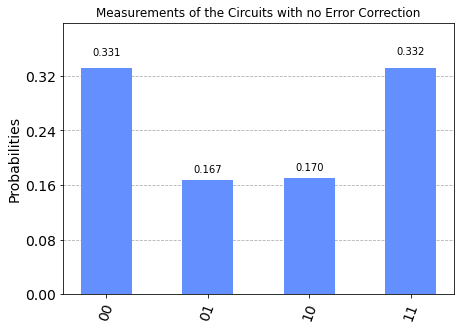

In [50]:
n_measurements = 10000
hits, sign_errors = run_simulation(np.array([1/3, 1/3, 1/3]), n_measurements, False)
print("Number of statevectors with sign flip errors={}, {}% of {} measurements."
  .format(sign_errors, np.round(sign_errors/n_measurements/.01, 2), n_measurements))
plot_histogram(hits, title='Measurements of the Circuits with no Error Correction')

Now, we will add the error detection/correction mechanism to the circuit. Now, the circuit mimics the ideal behavior of the circuit - to end in the state $\Phi^+$.  

Number of statevectors with sign flip errors=0, 0.0% of 10000 measurements.


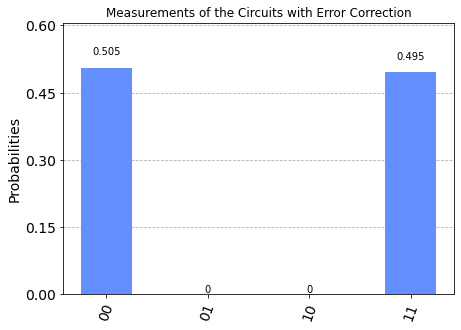

In [49]:
hits, sign_errors = run_simulation(np.array([1/3, 1/3, 1/3]), n_measurements, True)
print("Number of statevectors with sign flip errors={}, {}% of {} measurements."
  .format(sign_errors, np.round(sign_errors/n_measurements/.01, 2), n_measurements))
plot_histogram(hits, title='Measurements of the Circuits with Error Correction')

And there we go! You can change up the parameters of the simulation, such as the error gate probabilities, the number of measurements, etc. In any case, the effect of the error correction will persist. Note that these experiments were done on a noise-free simulation of a quantum computer - real quantum computers will almost certainly give less than theoretical results.